In [1]:
import json
import os
from pathlib import Path

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from rdkit.Chem import Draw, AllChem
from rdkit import DataStructs, RDLogger

import selfies as sf
import sentencepiece as spm

# Pairwise Analysis

The fingerprint type can introduce bias into the results when the Tanimoto score is computed using the same fingerprint as the model.
To minimize the selection bias, multiple fingerprints were employed, as listed in Table1.
Tanimoto exactness of each model was then computed across 15 different fingerprints (by including explicit bit vector type of the ECFP2 and ECFP4), and is presented as a matrix in below tables.
This approach was important to our assessment, as it decoupled the robustness of the models from the effectiveness and bias of the fingerprints.
The enhanced prediction accuracies of the MACCS, RDK4, RDK4-L, and ECFP2 fingerprints clearly confirmed the fingerprint dependency of the results.
The following matrix highlights the high performance and robustness of the ECFP4-SMILES model.
In addition, the true performance of each model averaged over 15 fingerprints is presented in Table2.
Ultimately, our top performing models, such as ECFP4, TT and its hashed variant, HashAP, ECFP2 and AEs remained neutral regardless of the choice of similarity metric.

In [2]:
# Results of evaluation on 50K testset performed every 25K step.
smiles_results = json.load(open('data/smiles_results.json'))
selfies_results = json.load(open('data/selfies_results.json'))

            
step=500000 #['25000', '50000', '75000', '100000', '125000', '150000', '175000', '200000', '225000', '250000', '275000', '300000', '325000', '350000', '375000', '400000', '425000', '450000', '475000', '500000']
var = 'Tc=1.0' #['Total Mol', 'Tc=1.0', 'String exacts', 'Stereo', 'Non-canonical','Others', 'Invalid', 'Mean Tc']

var_result = ['Total Mol', 'Tc=1.0', 'String exacts', 'Stereo', 'Non-canonical','Others', 'Invalid', 'Mean Tc']
variable_result=dict(zip(var_result, [0,1,2,3,4,5,6,7]))

smiles_result = {}
smiles_breakdown, FP_breakdown = {}, 'AEs'

for metric, results in smiles_results.items():
    smiles_result[metric]={}
    for fp, result in results.items():
        smiles_result[metric][fp]=result[str(step)][variable_result[var]]
        if metric ==FP_breakdown:
            smiles_breakdown[fp]=result[str(step)]
            
selfies_result = {}
selfies_breakdown, FP_breakdown = {}, 'AEs'
for metric, results in selfies_results.items():
    selfies_result[metric]={}
    for fp, result in results.items():
        selfies_result[metric][fp]=result[str(step)][variable_result[var]]
        if metric ==FP_breakdown:
            selfies_breakdown[fp]=result[str(step)]
        

Each cell shows the Tanimoto exactness (%) of selected fingerprint transformation to SMILES (row-wise) computed at the respective fingerprint encodings(columns-wise). The consistency in color code reflects the robustness, while the jumps represent the effect of selection bias. ECFP2* and ECFP4* represent explicit bit versions.

In [3]:
smiles_df = (pd.DataFrame.from_dict(smiles_result) * 100).round(1)
smiles_df

,MACCS,Avalon,RDK4,RDK4-L,HashAP,TT,HashTT,ECFP0,ECFP2,ECFP4,FCFP2,FCFP4,AEs,ECFP2*,ECFP4*
MACCS,77.4,33.3,38.0,39.8,32.2,33.2,33.2,52.2,34.7,32.5,48.6,33.5,34.7,37.0,33.3
Avalon,72.6,67.9,72.2,73.5,63.4,64.7,64.7,69.5,65.6,63.6,68.9,64.7,65.6,68.5,64.6
RDK4,66.9,60.0,90.9,91.5,59.8,61.1,61.1,62.5,60.2,58.3,62.3,59.6,60.2,64.3,59.6
RDK4-L,52.6,46.7,64.7,88.8,46.7,47.7,47.7,49.1,46.9,45.5,48.8,46.5,46.9,49.3,46.2
HashAP,86.5,83.8,89.6,90.2,85.2,85.5,85.5,84.3,83.1,82.5,84.0,82.8,83.1,86.1,84.1
TT,88.4,83.5,92.3,92.5,84.1,87.3,87.3,85.8,85.2,82.3,85.7,83.8,85.2,91.4,84.2
HashTT,86.2,81.4,90.2,90.5,82.1,85.3,85.5,83.9,83.3,80.4,83.8,81.8,83.3,89.2,82.2
ECFP0,3.3,1.3,2.1,2.7,1.2,1.3,1.3,4.0,1.4,1.2,2.9,1.3,1.4,1.8,1.4
ECFP2,86.0,75.8,83.1,83.1,73.6,76.0,76.0,84.7,82.7,74.4,84.5,76.5,82.7,96.2,76.0
ECFP4,95.1,92.6,95.7,95.7,90.8,92.4,92.4,93.5,93.1,92.1,93.3,92.4,93.1,96.6,94.8


In [4]:
selfies_df = (pd.DataFrame.from_dict(selfies_result, )*100).round(1)
selfies_df

,MACCS,Avalon,RDK4,RDK4-L,HashAP,TT,HashTT,ECFP0,ECFP2,ECFP4,FCFP2,FCFP4,AEs,ECFP2*,ECFP4*
MACCS,61.2,26.0,30.0,31.8,25.1,25.9,25.9,42.2,27.2,25.3,38.8,26.1,27.2,29.1,25.9
Avalon,50.8,46.6,50.2,51.7,43.7,44.6,44.6,48.9,45.2,43.9,48.2,44.5,45.2,47.2,44.5
RDK4,58.3,52.3,78.9,80.3,52.1,53.1,53.1,54.4,52.2,50.7,54.2,51.7,52.2,55.9,51.8
RDK4-L,45.0,39.8,55.0,76.8,39.8,40.6,40.6,42.0,39.9,38.8,41.7,39.6,39.9,42.0,39.5
HashAP,73.8,71.4,76.4,77.3,72.7,73.0,73.0,72.1,70.7,70.3,71.6,70.5,70.7,73.2,71.6
TT,81.1,76.8,84.8,85.3,77.5,80.2,80.2,78.6,78.0,75.6,78.4,76.8,78.0,83.7,77.4
HashTT,77.9,73.6,81.6,82.1,74.2,76.9,77.0,75.6,75.0,72.5,75.5,73.8,75.0,80.4,74.3
ECFP0,2.7,1.1,1.8,2.4,1.0,1.0,1.0,3.4,1.1,1.0,2.3,1.1,1.1,1.5,1.1
ECFP2,78.6,69.2,75.7,76.0,67.4,69.2,69.2,77.0,75.2,68.0,76.9,69.8,75.2,87.2,69.4
ECFP4,87.5,85.4,88.1,88.3,83.8,85.2,85.2,86.0,85.6,84.9,85.8,85.1,85.6,88.5,87.4


Table 2: Overall performance (%) of fingerprint decoders computed as the average Tanimoto exactness
score across 15 fingerprints.

In [5]:
pd.concat([smiles_df.mean(axis=1), selfies_df.mean(axis=1)], axis=1, keys=['SMILES', 'SELFIES']).T.round(2)

,MACCS,Avalon,RDK4,RDK4-L,HashAP,TT,HashTT,ECFP0,ECFP2,ECFP4,FCFP2,FCFP4,AEs
SMILES,39.57,67.33,65.22,51.61,85.09,86.60,84.61,1.91,80.75,93.57,20.27,71.73,81.27
SELFIES,31.18,46.65,56.75,44.07,72.55,79.49,76.36,1.57,73.60,86.16,16.30,64.71,74.98


# Breakdown of the top-1 accuracy

A complete breakdown of the top-1 accuracy results over the 50K test set for the top performer structural fingerprints is presented in Table, wherein the total accuracy is given based on the Tanimoto exactness.
We further separated the total accuracy into major components, using a simple string comparison.
Here, we note that identical structures based on the Tanimoto metric can be categorized depending on whether they are sourced from identical strings, stereochemistry, canonicalization, or other characteristics including chain length to symmetry properties.
The invalidity rates and mean Tanimoto scores are also given in Table.

A large fraction of our test set (i.e., ~30\%) incorporates stereochemistry, and the obtained results indicate that the models account for stereochemical information, yet they struggle to achieve an accurate picture of relative atom orientations. 
Indeed, for the best-performing fingerprint, ECFP4, the stereochemical errors equaled ~20\%. 
We therefore examined the stereochemically-inconsistent predictions by removing the stereochemical information to determine whether these predictions were string-exact to the ground truths.
It was found that in the majority of cases, the models treat reverse (or opposite) stereochemistries as cis/trans or clockwise/anti-clockwise. 
Moreover, predictions featuring stereochemistry also existed even in the cases where the ground truths possessed no stereocenter, or vice versa.

To ensure the full capacity of the SMILES representation, our dataset was not subjected to canonicalization prior to training.
It was found that our models were able to produce noncanonical instances of ground-truth SMILES, and the rates of predicting chemically equivalent SMILES varied from 1.6 to 4.8\%, depending on the fingerprint type.
In addition, it should be noted that the Kekule forms play an important role in non-canonical predictions since switches in the Kekule representations can alter the SMILES enumerations.
Regarding the invalidity rates, SELFIES provided robust conversions with no invalid cases, as expected.
Furthermore, SMILES performed comparably well, with invalidity rates of only ~0.2-0.3\%.
Representative predictions displaying the changes in stereochemistry, Kekule forms, and enumerations are given in Supplementary Table.

In [6]:
smiles_table3 = (pd.DataFrame(smiles_breakdown, index=['Total Mol', 'Tc=1.0', 'String exacts', 'Stereo', 'Non-canonical','Others', 'Invalid', 'Mean Tc']) * 100).round(2)
smiles_table3#[['MACCS', 'Avalon', 'HashAP', 'TT', 'AEs', 'ECFP4']] 

,MACCS,Avalon,RDK4,RDK4-L,HashAP,TT,HashTT,ECFP0,ECFP2,ECFP4,FCFP2,FCFP4,AEs
Total Mol,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,4999700.00,4999700.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00
Tc=1.0,34.67,65.60,60.22,46.90,83.06,85.21,83.27,1.37,82.74,93.14,16.93,68.51,83.48
String exacts,22.32,44.68,42.00,33.27,58.72,57.75,56.28,0.79,52.04,64.59,10.35,45.74,52.09
Stereo,8.22,14.86,12.55,9.27,19.15,19.25,18.89,0.38,17.75,21.20,4.25,16.11,18.05
Non-canonical,1.56,3.48,3.17,2.52,4.35,4.25,4.13,0.05,3.70,4.82,0.89,3.53,3.72
Others,2.56,2.59,2.50,1.84,0.85,3.97,3.97,0.16,9.24,2.53,1.44,3.13,9.62
Invalid,0.23,0.36,0.23,0.20,0.27,0.31,0.27,0.32,0.23,0.23,0.26,0.35,0.28
Mean Tc,81.93,90.49,87.69,81.04,95.55,96.35,95.48,48.06,96.42,98.11,72.62,92.79,96.68


In [7]:
selfies_table3 = (pd.DataFrame(selfies_breakdown, index=['Total Mol', 'Tc=1.0', 'String exacts', 'Stereo', 'Non-canonical','Others', 'Invalid', 'Mean Tc']) * 100).round(2)
selfies_table3#[['MACCS', 'Avalon', 'HashAP', 'TT', 'AEs', 'ECFP4']] 


,MACCS,Avalon,RDK4,RDK4-L,HashAP,TT,HashTT,ECFP0,ECFP2,ECFP4,FCFP2,FCFP4,AEs
Total Mol,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,4999700.00,4999700.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00
Tc=1.0,27.18,45.19,52.20,39.88,70.73,78.04,74.98,1.11,75.16,85.64,13.39,61.59,76.65
String exacts,17.68,31.31,37.20,28.75,50.90,54.04,51.83,0.66,48.17,60.53,8.35,42.20,49.07
Stereo,5.86,9.35,10.02,7.33,15.19,16.68,16.07,0.28,15.60,18.47,3.14,13.62,15.93
Non-canonical,1.49,2.80,3.01,2.40,4.02,4.06,3.81,0.06,3.53,4.71,0.76,3.28,3.63
Others,2.16,1.72,1.98,1.40,0.63,3.26,3.28,0.12,7.86,1.94,1.14,2.49,8.02
Invalid,0.00,0.02,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Mean Tc,77.78,81.54,84.39,77.80,90.75,93.87,92.42,47.00,93.91,95.13,70.11,89.99,94.39


# Plot results of pairwise evaluation

In [8]:

def pairwise_plot(results_df, title, name=None, cmap_color = 'YlOrRd'):
    ylabels = ['MACCS', 'Avalon', 'RDK4', 'RDK4-L', 'HashAP', 'TT', 'HashTT', 'ECFP0', 'ECFP2', 'ECFP4', 'FCFP2', 'FCFP4', 'AEs' ]
    xlabels = ['MACCS', 'Avalon', 'RDK4', 'RDK4-L', 'HashAP', 'TT', 'HashTT', 'ECFP0', 'ECFP2', 'ECFP4', 'FCFP2', 'FCFP4', 'AEs', 'ECFP2*', 'ECFP4*' ]

    fig, ax = plt.subplots(nrows=1, ncols=1, 
                            #gridspec_kw={'height_ratios': [10, 1], }, 
                            figsize=(10, 10), dpi=300, facecolor='white')
    axh = sns.heatmap(results_df, 
                      annot=True, 
                      ax=ax,
                      vmax =  130,#np.max(ig_grid, ), 
                      vmin = 30,
                      linewidth=0.6, 
                      square=True, 
                      cmap= cmap_color,
                      #alpha = 0.2,
                      cbar = None,
                      #cbar_kws={ 'location':'right', 'orientation':'vertical'}
                      annot_kws={"fontsize":14}
                     )
    axh.figure.axes[-1].xaxis.label.set_size(16)
    fig.suptitle(title, fontsize = 16)

    # Set common labels
    ax.set_xticklabels(xlabels, rotation = 90, fontsize=16)
    ax.set_yticklabels(ylabels, rotation = 0, fontsize=16)
    ax.set_xlabel('Fingerprint type', fontsize = 16)
    ax.set_ylabel('Structual fingerprint model', fontsize = 16)
    
    ax.tick_params(axis='both', which='major',  labelbottom = False, bottom=False, top = True, labeltop=True)

    fig.tight_layout()
    if name:
        fig.savefig(name)
    return fig

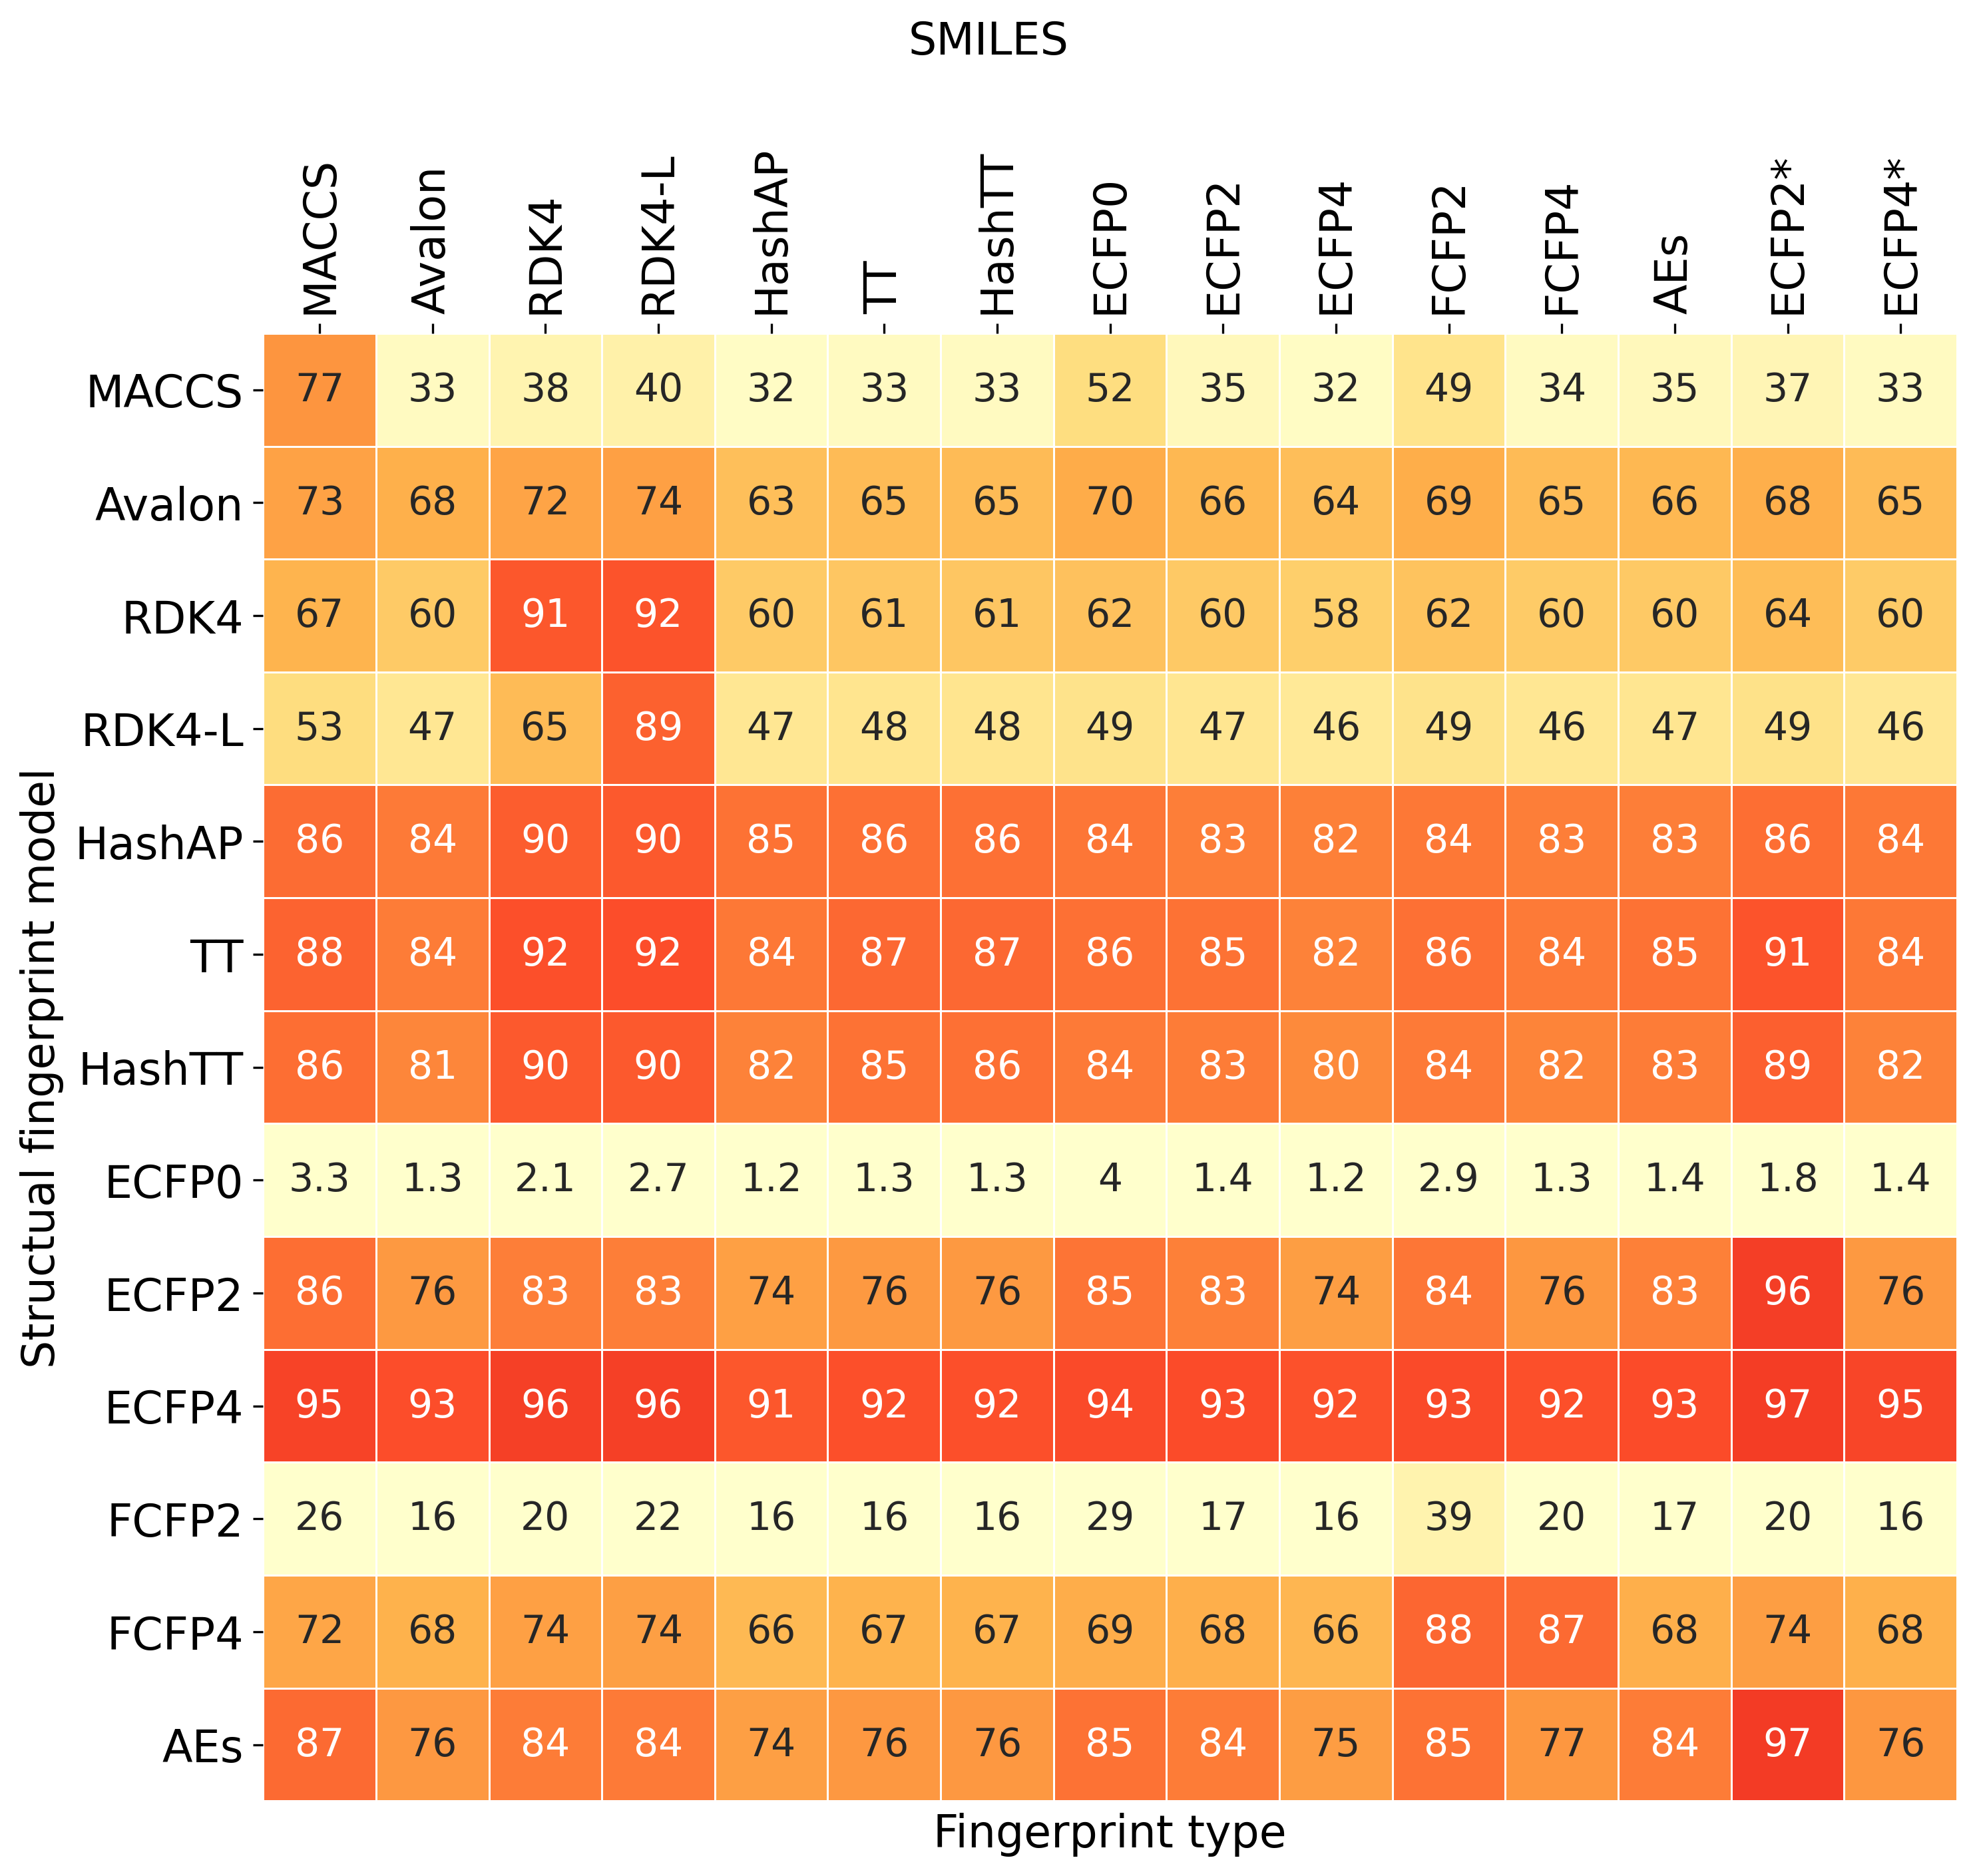

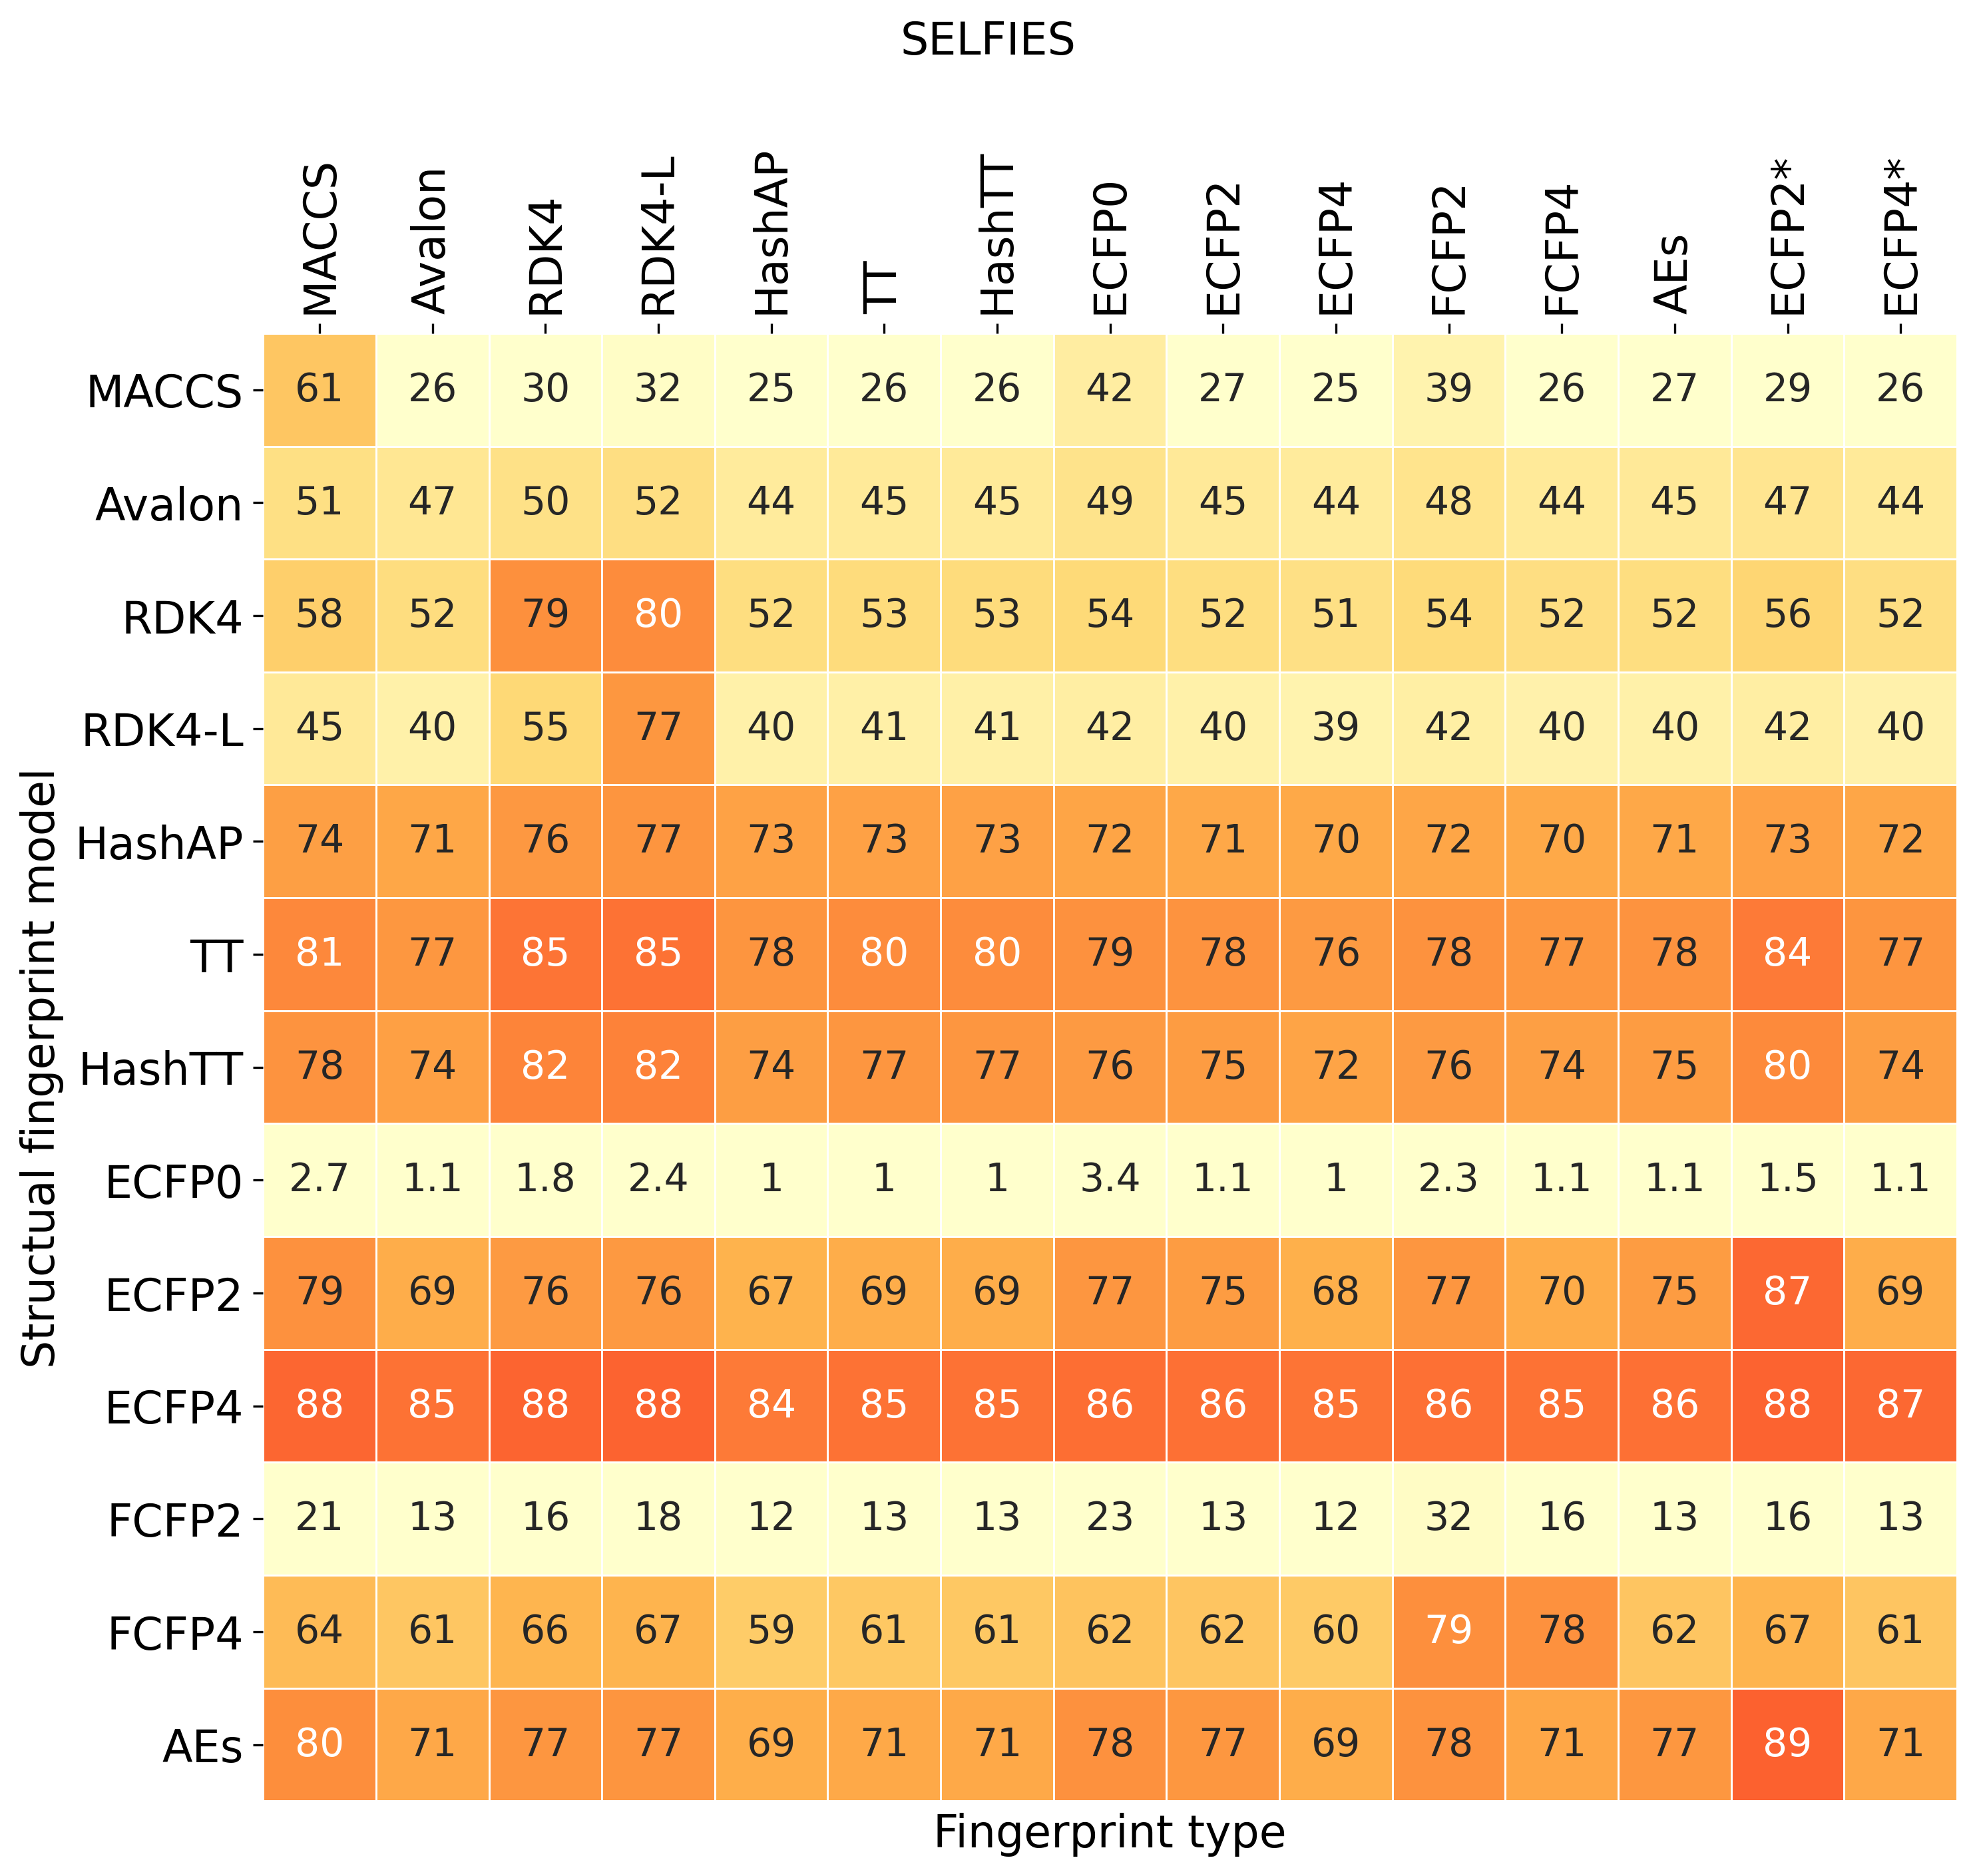

In [10]:
smiles_fig  = pairwise_plot(smiles_df, 'SMILES',   'Figures/pairwise_smiles_results.png')
selfies_fig = pairwise_plot(selfies_df, 'SELFIES', 'Figures/pairwise_selfies_results.png')
